__собираем статистики по объявлениям о продаже земли__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Пн 10 июн 2024 14:31:49 MSK


# загружаем данные

In [2]:
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_pickle('data/2024/df_land.pkl')
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

7473

,title,address,latitude,longitude,priceM,dt
172,"участок, 5.1 сот., садоводство","севастополь,р-н нахимовский,качинский район ,интернационалист садовое товарищество",44.794194,33.59065,1.50,2024-06-07
3889,"участок 8,9 сот. (снт, днп)","севастополь,снт сапун-гора,ул.лейтенанта миронова",44.568526,33.569656,6.45,2024-06-10
5262,"участок 1,8 га (снт, днп)","бахчисарай,с.голубинка,ул.ленина",44.594014,33.913917,7.00,2024-06-10


---

In [4]:
df_ = pd.read_pickle('data/2023/data_land.pkl').rename(columns={'adr':'address'})
df_['dt'] = df_['ts'].dt.date
display( len(df_) )
display( df_.sample(3)[cols] )

18854

,title,address,latitude,longitude,priceM,dt
776,Участок 5 сот. (ИЖС),"Севастополь,ул. Бориса Шейнина, 97",44.576206,33.558265,2.70,2022-09-08
14745,Участок 1 сот. (ИЖС),"Севастополь,с. Угловое",44.820669,33.606675,0.30,2022-11-15
10407,Участок 6 сот. (ИЖС),"Севастополь,с. Штурмовое, Придорожная ул.",44.567344,33.62598,1.50,2022-10-14


In [5]:
df_ = (
        df_
        .dropna(subset=['dt','url'])
        .drop_duplicates(['dt','url'])
        .drop(columns=['adr_orig','obj_name','avito_page'])
    )
display( len(df_) )
cols = ['title','address','latitude','longitude','priceM','dt','url']
display( df_.sample(3)[cols] )

18727

,title,address,latitude,longitude,priceM,dt,url
7677,Участок 10 сот. (ИЖС),"Севастополь,садоводческое товарищество Теремок",44.514566,33.508705,5.20,2022-09-22,https://avito.ru/2346470203
10114,"Участок 4,5 сот. (ИЖС)","Севастополь,ТСН СНТ Парус-1, 64",44.637023,33.569288,2.35,2022-10-14,https://avito.ru/2619766280
16044,Участок 5 сот. (ИЖС),"Севастополь,Нахимовский район",44.616495,33.525135,1.94,2022-11-28,https://avito.ru/2406481547


In [6]:
# df_['dt'].drop_duplicates()

In [7]:
# history_date = df_['dt'].max()
history_date = pd.to_datetime('2023-01-10').date()
display(history_date)

datetime.date(2023, 1, 10)

In [8]:
df = pd.concat([df,df_]).reset_index(drop=True)
display( len(df) )
del df_

26200

In [9]:
import numpy as np
df['log_priceM'] = df['priceM'].apply(lambda x: np.log(x+1.))

---

In [10]:
# df['dt'].drop_duplicates().sort_values()

In [11]:
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-04').date() ]
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-05').date() ]
# display( len(df) )
# df = df.reset_index(drop=True)

---

In [12]:
df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26200 entries, 0 to 26199
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   url                 26200 non-null  object        
 1   place               26200 non-null  object        
 2   title               26200 non-null  object        
 3   subtitle            3056 non-null   object        
 4   price               26200 non-null  int64         
 5   address             26200 non-null  object        
 6   description         26200 non-null  object        
 7   ts                  26200 non-null  datetime64[ns]
 8   area                26200 non-null  float64       
 9   is_IJS              26200 non-null  bool          
 10  priceM              26200 non-null  float64       
 11  priceMU             26200 non-null  float64       
 12  area_size_category  26167 non-null  category      
 13  address_orig        7473 non-null   object    

In [14]:
df.loc[ df['address']=='квартал Старый Город', ['latitude','longitude']] = None
df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 
df.loc[ df['address'].str.lower().str.match('анталья'), ['latitude','longitude'] ] = None 


df.loc[ df['address'].str.lower().str.match('бахчисарай.*надежда.*'), ['latitude','longitude'] ] = None 
df.loc[ df['address'].str.lower().str.match('бахчисарай.*с.дачное.*'), ['latitude','longitude'] ] = None 
df.loc[ df['longitude']<30., ['latitude','longitude'] ] = None 

In [15]:
display( len(df) )
df = df.dropna(subset=['latitude','longitude'])
display( len(df) )

26200

26178

In [16]:
# print(len(df))
# # выкидываем "ущербные" варианты 
# df = df.query('is_IJS')
# print(len(df))

In [17]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

,title,address,latitude,longitude,priceM,dt,url
19035,"Участок 11,5 сот. (ИЖС)","Севастополь,с. Гончарное, Раздольная ул., 20",44.46,33.71,2.75,2022-11-01,https://avito.ru/2500368907
11100,Участок 18 сот. (ИЖС),"Севастополь,Готская ул., 122А",44.57,33.47,24.00,2022-09-15,https://avito.ru/2239954933
8059,Участок 10 сот. (ИЖС),"Севастополь,с. Широкое, ул. Булгакова",44.48,33.78,4.00,2022-09-08,https://avito.ru/2529736058


---

In [18]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
display( dt_min,history_date,dt_max )

datetime.date(2022, 9, 8)

datetime.date(2023, 1, 10)

datetime.date(2024, 6, 10)

In [19]:
gdf_history = gdf.query(f'dt <= @history_date')
gdf = gdf.query(f'dt > @history_date')

In [20]:
display( len(gdf_history) )
display( len(gdf) )

16994

9184

In [21]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# gdf[ (gdf['place']=='sevastopol') & (gdf['address'].str.match(r'.*Судак.*')) ][cols]

In [22]:
# gdf['place'].unique()

# общая статистика

In [23]:
gdf[['title','address','priceM','geometry']].sample(512).explore()

In [24]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(512).explore()

In [25]:
( 
    gdf.query('place=="sudak"')
    [['title','address','priceM','area_size_category','geometry']]
    #.explore('area_size_category', legend=True) 
    .explore()    
)

In [26]:
# gdf[
#     gdf['address'].str.match(r'бахчисарай.*с.дачное.*')
# ][['title','address','priceM','area_size_category','geometry']]

In [27]:
(
    gdf.query('place=="bahchisaray"')
    [['title','address','priceM','area_size_category','geometry']]
    #.sample(100)
    .explore() #'area_size_category', legend=True) 
)

In [28]:
# cols = ['title','adr','priceM','house_size_category','place','url','geometry']

In [29]:
percentiles=[.01,.05,.1,.25,.5,.75,.9]
stat = gdf.groupby(['place','area_size_category','dt'],observed=True)['priceM'].describe(percentiles=percentiles)
stat_history = gdf_history.groupby(['place','area_size_category','dt'],observed=True)['priceM'].describe(percentiles=percentiles)

display( stat )
display( stat_history )

count  mean   std  min   1%   5%  \
place       area_size_category dt                                              
bahchisaray <1                 2024-06-07    2.00  0.90  0.14 0.80 0.80 0.81   
                               2024-06-10    2.00  0.90  0.14 0.80 0.80 0.81   
            1-2                2024-06-07    5.00  2.60  2.53 0.50 0.54 0.70   
                               2024-06-10    5.00  2.60  2.53 0.50 0.54 0.70   
            2-4                2024-06-07    6.00  2.71  0.82 1.80 1.80 1.82   
                               2024-06-10    6.00  3.37  1.39 1.80 1.83 1.98   
            4-8                2024-06-07  120.00  2.00  1.23 0.15 0.30 0.40   
                               2024-06-10  124.00  1.97  1.27 0.15 0.30 0.40   
            8-20               2024-06-07  150.00  2.20  2.26 0.23 0.32 0.47   
                               2024-06-10  149.00  2.20  2.21 0.23 0.32 0.50   
            20+                2024-06-07  348.00  5.41 10.28 0.00 0.00 0.37   
                               2024-06-10  352.00  5.40 10.45 0.00 0.00 0.35   
sevastopol  <1                 2024-06-04    2.00  1.15  0.49 0.80 0.81 0.84   
                               2024-06-05    2.00  1.15  0.49 0.80 0.81 0.84   
                               2024-06-07   47.00  2.93  1.08 0.80 0.80 1.11   
                               2024-06-10   52.00  2.99  1.04 0.80 0.80 1.13   
            1-2                2024-06-04    6.00  4.99  4.46 0.55 0.62 0.91   
                               2024-06-05    5.00  5.13  4.97 0.55 0.61 0.84   
                               2024-06-07   58.00  3.84  2.81 0.98 1.16 1.50   
                               2024-06-10   55.00  3.71  2.89 0.55 0.78 1.21   
            2-4                2024-06-04  136.00  3.48  2.56 1.10 1.29 1.54   
                               2024-06-05  138.00  3.40  2.40 1.10 1.29 1.55   
                               2024-06-07  566.00  3.28  1.95 0.65 1.30 1.66   
                               2024-06-10  588.00  3.24  1.76 0.65 1.30 1.70   
            4-8                2024-06-04  420.00  5.23  5.01 0.60 1.20 1.80   
                               2024-06-05  409.00  5.02  4.73 0.60 1.00 1.77   
                               2024-06-07 1094.00  3.79  2.63 0.39 0.87 1.30   
                               2024-06-10 1187.00  3.91  3.23 0.39 0.90 1.35   
            8-20               2024-06-04  268.00  7.53 10.43 0.99 1.38 1.97   
                               2024-06-05  278.00  7.34 10.23 0.95 1.29 1.99   
                               2024-06-07  616.00  5.10  6.03 0.00 0.73 1.34   
                               2024-06-10  656.00  5.24  7.65 0.60 0.85 1.40   
            20+                2024-06-04   23.00 54.93 50.46 2.70 2.77 3.03   
                               2024-06-05   28.00 52.39 52.14 2.70 2.78 3.07   
                               2024-06-07  284.00  9.65 21.07 0.00 0.75 1.30   
                               2024-06-10  304.00  9.37 19.52 0.00 1.00 1.46   
sudak       <1                 2024-06-07   10.00  1.54  1.54 0.50 0.50 0.50   
                               2024-06-10    9.00  1.15  1.00 0.50 0.50 0.50   
            1-2                2024-06-07    4.00  4.12  2.07 2.00 2.03 2.15   
                               2024-06-10    5.00  4.06  1.80 2.00 2.04 2.20   
            2-4                2024-06-07   16.00  5.47  4.65 1.60 1.65 1.86   
                               2024-06-10   17.00  5.20  4.64 0.94 1.05 1.47   
            4-8                2024-06-07  200.00  3.51  3.26 0.00 0.60 1.09   
                               2024-06-10  211.00  3.45  3.24 0.00 0.51 1.04   
            8-20               2024-06-07   69.00  6.13  7.24 0.88 0.96 1.14   
                               2024-06-10   68.00  5.72  4.81 0.88 0.96 1.14   
            20+                2024-06-07   31.00 10.67  8.24 0.80 1.01 2.10   
                               2024-06-10   30.00 10.51  8.34 0.80 1.00 2.04   

                                           

count  mean   std  min   1%   5%  \
place      area_size_category dt                                             
sevastopol <1                 2022-09-08   4.00  4.19  7.22 0.30 0.30 0.30   
                              2022-09-12   4.00  4.19  7.22 0.30 0.30 0.30   
                              2022-09-13   3.00  5.49  8.25 0.32 0.33 0.40   
                              2022-09-15   4.00  4.19  7.22 0.30 0.30 0.30   
                              2022-09-16   4.00  4.19  7.22 0.30 0.30 0.30   
...                                         ...   ...   ...  ...  ...  ...   
           20+                2022-11-04  33.00 30.70 29.06 1.50 1.50 1.53   
                              2022-11-07  36.00 32.14 28.97 1.50 1.52 2.26   
                              2022-11-15  39.00 29.43 25.44 1.00 1.21 2.86   
                              2022-11-28  32.00 29.37 25.54 3.00 3.62 5.28   
                              2023-01-10  23.00 41.50 48.51 1.55 1.87 3.15   

                                          10%   25%   50%   75%   90%    max  
place      area_size_category dt                                              
sevastopol <1                 2022-09-08 0.30  0.31  0.73  4.61 10.84  15.00  
                              2022-09-12 0.30  0.31  0.73  4.61 10.84  15.00  
                              2022-09-13 0.48  0.73  1.15  8.07 12.23  15.00  
                              2022-09-15 0.30  0.31  0.73  4.61 10.84  15.00  
                              2022-09-16 0.30  0.31  0.73  4.61 10.84  15.00  
...                                       ...   ...   ...   ...   ...    ...  
           20+                2022-11-04 3.40  9.98 18.00 40.00 69.60 125.00  
                              2022-11-07 4.00 10.00 20.85 42.50 70.50 125.00  
                              2022-11-15 5.20  9.99 21.00 38.95 68.40 115.00  
                              2022-11-28 7.65 10.00 21.00 38.48 59.40 120.00  
                              2023-01-10 5.60 14.50 21.00 50.00 75.60 220.00  

[96 rows x 12 columns]

In [30]:
# percentiles=[.01,.05,.1,.25,.5,.75,.9]
# stat = gdf.groupby(['place','area_size_category','dt'],observed=True)['priceM'].describe(percentiles=percentiles)
# display( stat )

In [31]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%']
#sizes = stat.reset_index()['area_size_category'].unique()
sizes = [ '2-4', '4-8', '8-20']
display( sizes )

['2-4', '4-8', '8-20']

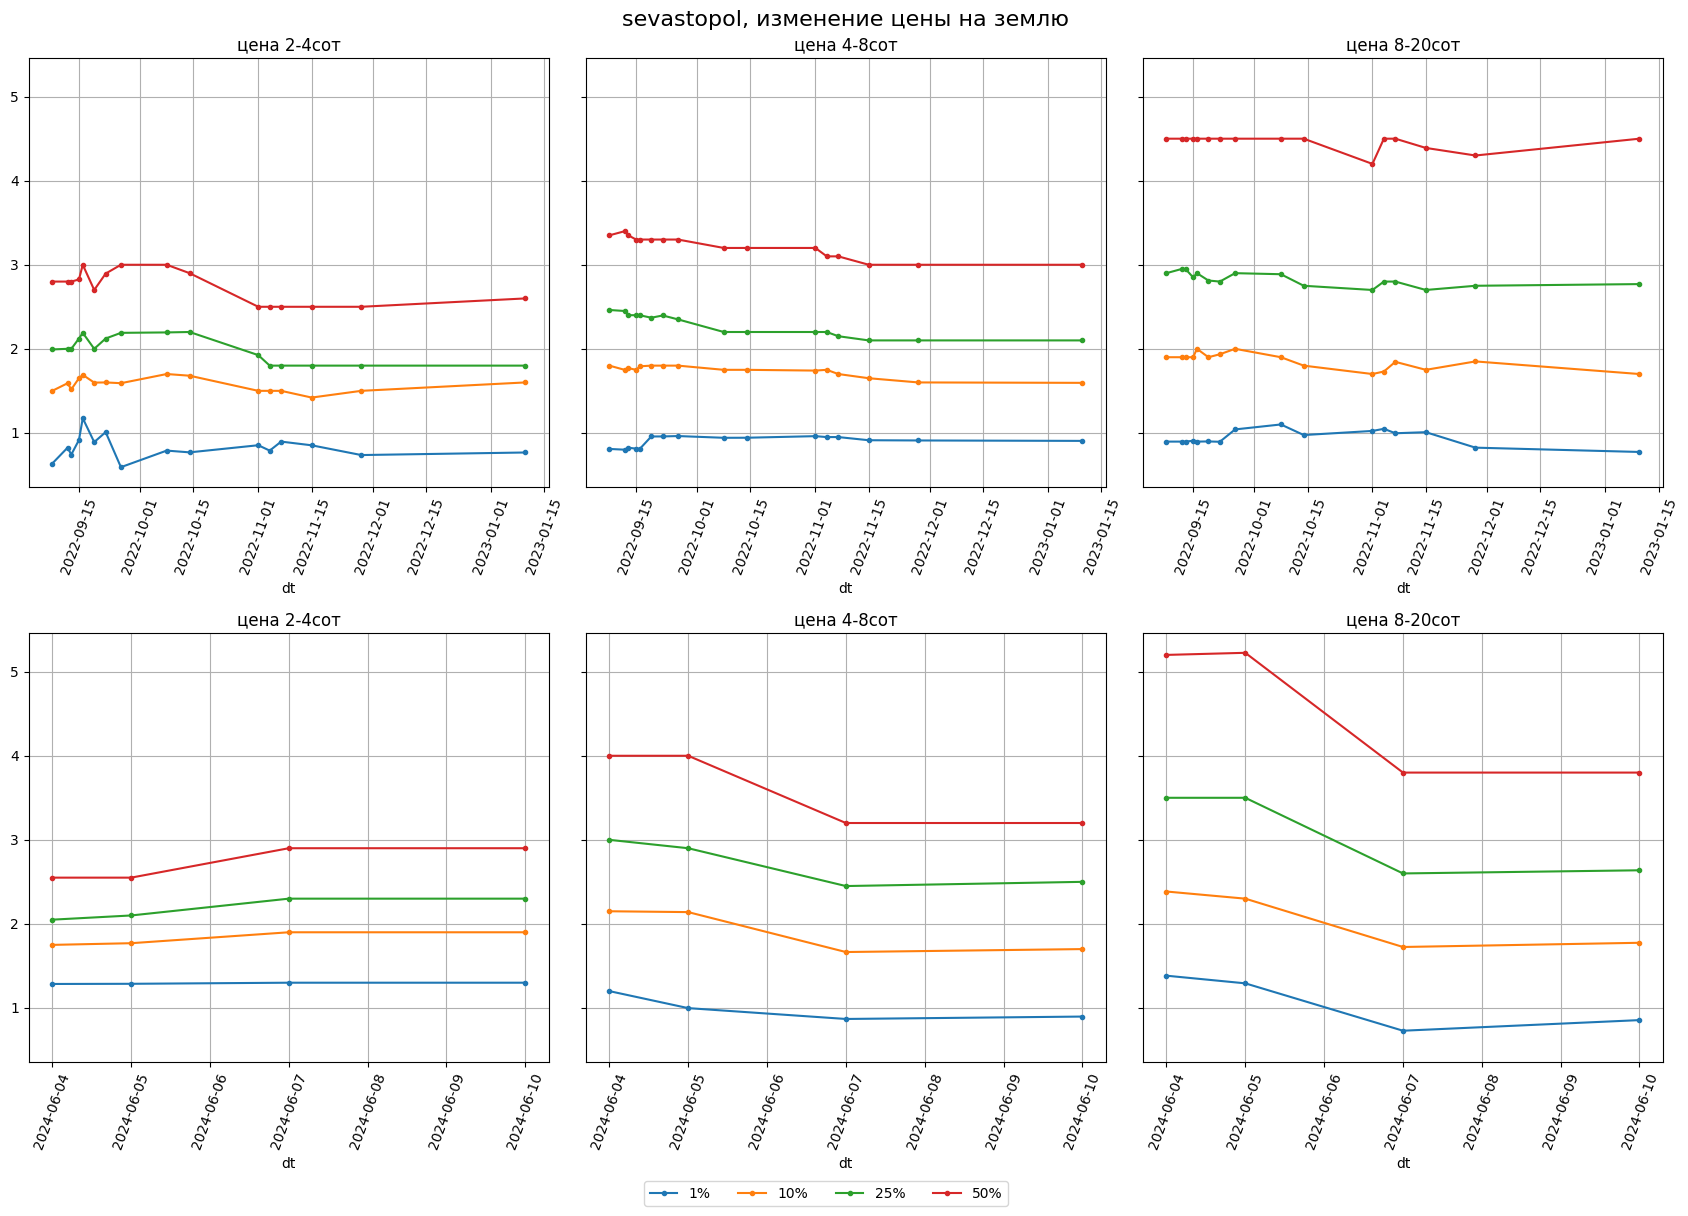

In [32]:
place = 'sevastopol'

fig, ax = plt.subplots(2,len(sizes),figsize=(17,12), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}сот', grid=True,ax=ax[1][i],legend=False, rot=70, style='.-' )   
    stat_history.loc[(place,s),cols].plot(title=f'цена {s}сот', grid=True,ax=ax[0][i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на землю', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

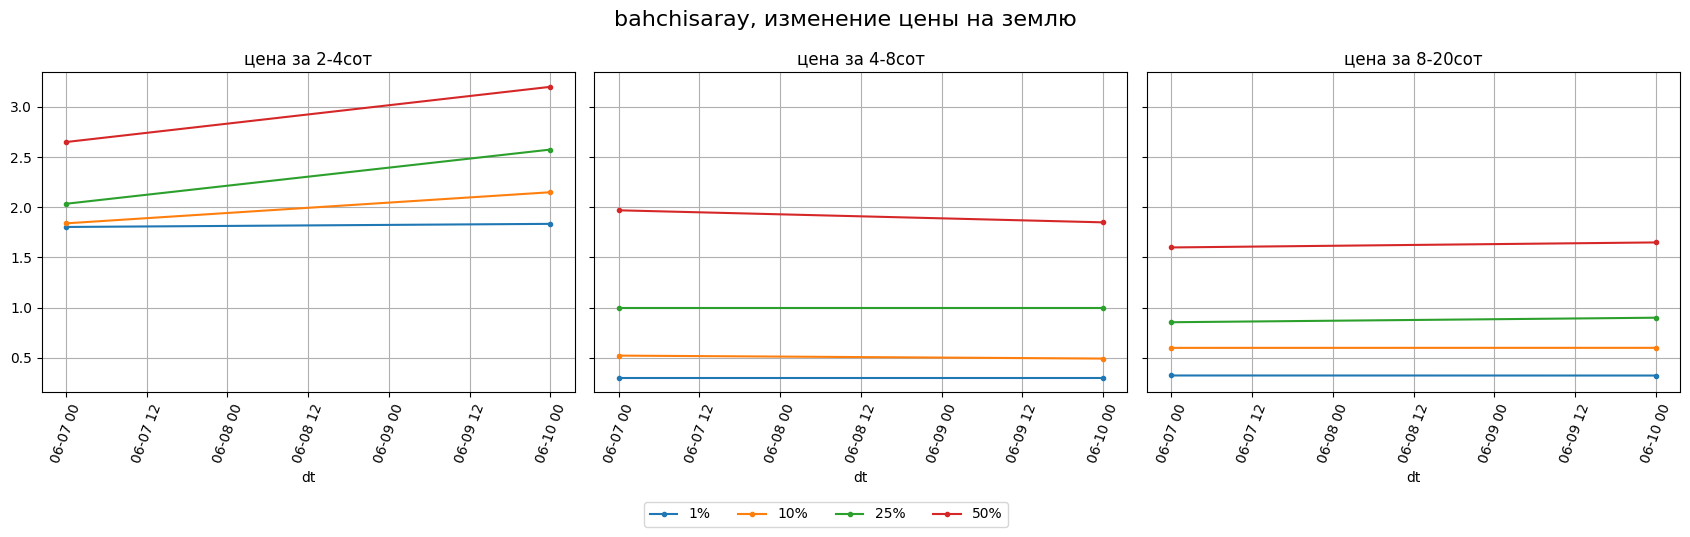

In [33]:
place = 'bahchisaray'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,5), sharey=True )
for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена за {s}сот', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на землю', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

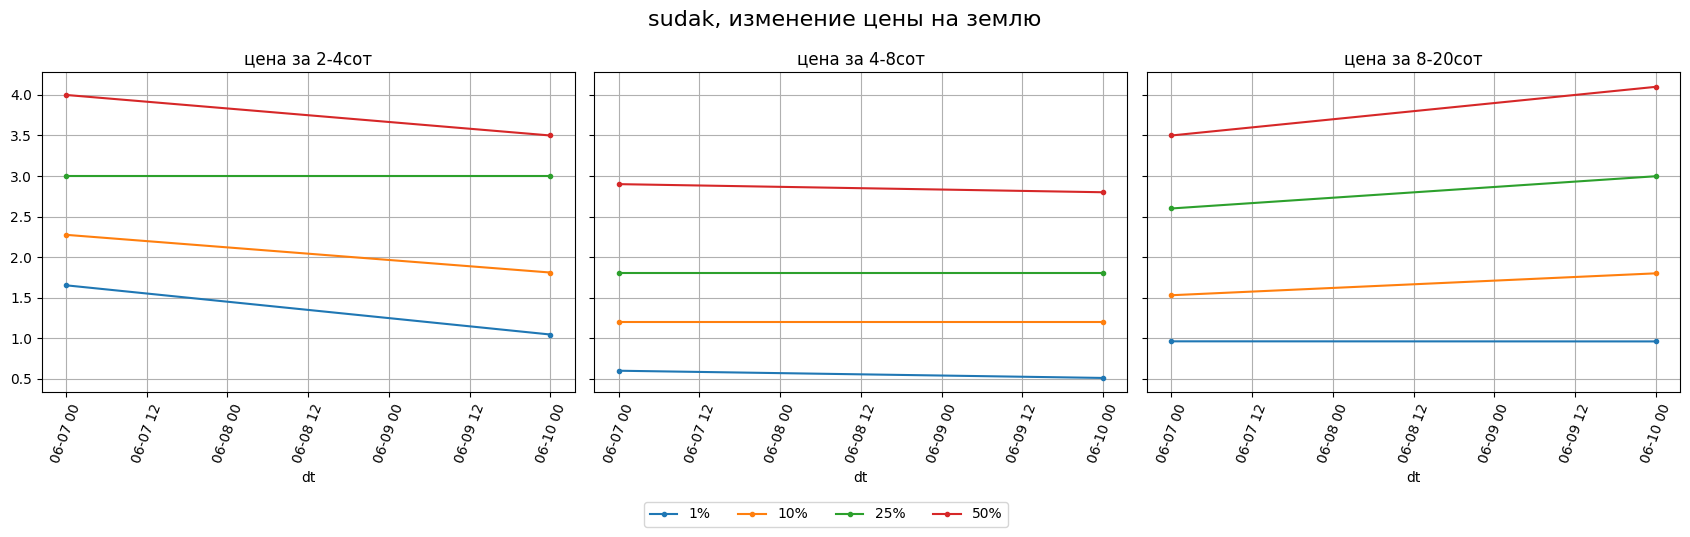

In [34]:
place = 'sudak'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,5), sharey=True )
for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена за {s}сот', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на землю', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

# актуальная цена

In [35]:
display(len(gdf))
gdf_last = gdf[ gdf['dt'] == gdf['dt'].max() ]
display(len(gdf_last))

9184

3831

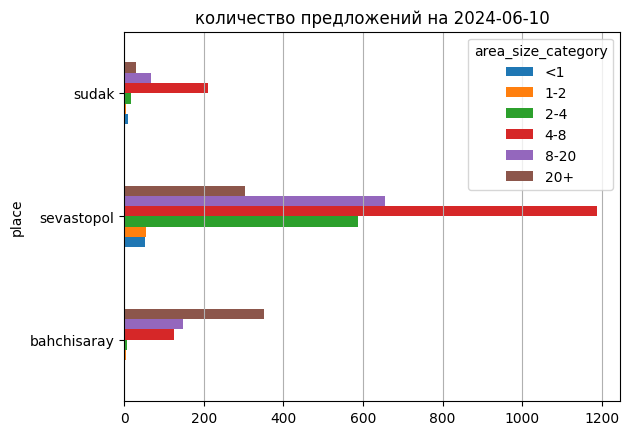

In [36]:
(
gdf_last
.groupby(['area_size_category','place'],observed=False)['url'].count().reset_index()
.pivot(index='place', columns='area_size_category', values='url')
.plot.barh(title='количество предложений на '+ str( gdf['dt'].max() ))
.grid(axis='x')    
)

In [37]:
(
    gdf_last
    .groupby(['place','area_size_category'],observed=False)
    ['priceM'].describe(percentiles=percentiles)
)

count  mean   std  min   1%   5%  10%  25%  \
place       area_size_category                                                
bahchisaray <1                    2.00  0.90  0.14 0.80 0.80 0.81 0.82 0.85   
            1-2                   5.00  2.60  2.53 0.50 0.54 0.70 0.90 1.50   
            2-4                   6.00  3.37  1.39 1.80 1.83 1.98 2.15 2.58   
            4-8                 124.00  1.97  1.27 0.15 0.30 0.40 0.49 1.00   
            8-20                149.00  2.20  2.21 0.23 0.32 0.50 0.60 0.90   
            20+                 352.00  5.40 10.45 0.00 0.00 0.35 0.55 1.00   
sevastopol  <1                   52.00  2.99  1.04 0.80 0.80 1.13 1.31 2.50   
            1-2                  55.00  3.71  2.89 0.55 0.78 1.21 1.58 2.25   
            2-4                 588.00  3.24  1.76 0.65 1.30 1.70 1.90 2.30   
            4-8                1187.00  3.91  3.23 0.39 0.90 1.35 1.70 2.50   
            8-20                656.00  5.24  7.65 0.60 0.85 1.40 1.77 2.64   
            20+                 304.00  9.37 19.52 0.00 1.00 1.46 1.99 2.70   
sudak       <1                    9.00  1.15  1.00 0.50 0.50 0.50 0.50 0.55   
            1-2                   5.00  4.06  1.80 2.00 2.04 2.20 2.40 3.00   
            2-4                  17.00  5.20  4.64 0.94 1.05 1.47 1.81 3.00   
            4-8                 211.00  3.45  3.24 0.00 0.51 1.04 1.20 1.80   
            8-20                 68.00  5.72  4.81 0.88 0.96 1.14 1.80 3.00   
            20+                  30.00 10.51  8.34 0.80 1.00 2.04 2.83 4.58   

                                50%   75%   90%    max  
place       area_size_category                          
bahchisaray <1                 0.90  0.95  0.98   1.00  
            1-2                2.00  2.00  5.00   7.00  
            2-4                3.20  3.68  4.75   5.80  
            4-8                1.85  2.50  3.70   6.90  
            8-20               1.65  2.60  3.56  16.20  
            20+                2.10  4.56 12.45 100.00  
sevastopol  <1                 3.12  3.73  4.18   4.90  
            1-2                3.30  4.20  5.54  18.50  
            2-4                2.90  3.70  4.46  22.40  
            4-8                3.20  4.40  6.40  70.00  
            8-20               3.80  5.60  8.22 120.00  
            20+                3.50  5.00 18.20 150.00  
sudak       <1                 0.75  1.50  1.92   3.60  
            1-2                3.80  4.80  5.94   6.70  
            2-4                3.50  5.60  8.72  20.00  
            4-8                2.80  3.85  5.90  30.00  
            8-20               4.10  6.50 11.50  22.00  
            20+                7.15 15.23 22.50  30.00

# цены на карте

In [38]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [39]:
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [40]:
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# gdf_last.query('place=="sevastopol"')[cols]

In [41]:
# gdf_last[gdf_last['place']=='sevastopol'][cols]

## Севастополь

In [42]:
frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_sevastopol.explore()

In [43]:
# gdf_last.query('place=="sevastopol"')[['priceM']].describe([.9,.95,.99]).T

In [44]:
grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )
grid_values = ( 
    grid
    # .sjoin( gdf_last.query('(place=="sevastopol")&(priceM<10.0)'), how='inner',)
    .sjoin( gdf_last.query('place=="sevastopol"'), how='inner',)
    .groupby(['hex_id'])
    [['log_priceM','priceM']]
    .median()
    .reset_index()
)

(
    grid
    .merge(grid_values,on='hex_id')
    [['priceM','geometry','log_priceM',]]
    .explore(column='log_priceM',cmap='rainbow')
)

## Судак

In [45]:
frame_sudak = gpd.GeoDataFrame([{ # все предложения
            'place':'sudak', 
            'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

In [46]:
# gdf_last.query('place=="sudak"')[['priceM']].describe([.9,.95,.99]).T

In [47]:
grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=8 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sudak"'), how='inner',)
    .groupby(['hex_id'])
   [['log_priceM','priceM']]
    .median()
    .reset_index()
)

(
    grid
    .merge(grid_values,on='hex_id')
    [['priceM','geometry','log_priceM',]]
    .explore(column='log_priceM',cmap='rainbow')
)

# районы Севастополя

In [48]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

In [49]:
display(frames)

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка (старый)","POLYGON ((33.52932 44.59395, 33.53014 44.59336, 33.53265 44.59419, 33.53374 44.59431, 33.53651 44.59412, 33.54230 44.59142, 33.54644 44.58708, 33.54577 44.58522, 33.54406 44.58269, 33.54076 44.58366, 33.53883 44.58383, 33.53664 44.58511, 33.53142 44.58626, 33.53025 44.58780, 33.53048 44.58861, 33.53046 44.58847, 33.53167 44.59039, 33.53092 44.59122, 33.52951 44.59116, 33.52879 44.59244, 33.52895 44.59355, 33.52932 44.59395))"
6,"Севастополь, кр.горка (новый)","POLYGON ((33.54571 44.58517, 33.54652 44.58705, 33.54904 44.58565, 33.55000 44.58541, 33.55054 44.58522, 33.55089 44.58423, 33.55253 44.58415, 33.55326 44.58470, 33.55368 44.58431, 33.55371 44.58320, 33.55522 44.58246, 33.55548 44.58219, 33.55564 44.58115, 33.55564 44.58115, 33.55644 44.58055, 33.55694 44.57984, 33.55718 44.57912, 33.55936 44.57821, 33.56045 44.57706, 33.56229 44.57552, 33.56283 44.57476, 33.55749 44.57202, 33.55674 44.57395, 33.55618 44.57483, 33.55600 44.57601, 33.55286 44.57827, 33.55293 44.57910, 33.55259 44.58172, 33.55269 44.58302, 33.55003 44.58331, 33.54838 44.58436, 33.54571 44.58509, 33.54571 44.58517))"
7,"Севастополь, Малахов курган","POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))"
8,"Севастополь, Благополучный","POLYGON ((33.56498 44.57145, 33.56348 44.57083, 33.56274 44.57070, 33.56182 44.57017, 33.56179 44.56990, 33.55967 44.56941, 33.55751 44.57190, 33.55756 44.57213, 33.56302 44.57463, 33.56498 44.57145))"


In [50]:
frames.explore('area_name', legend=True)

In [51]:
area_name=[
    #'Севастополь, парк 60-летия СССР',
    #'Севастополь, Хрусталёва/Хрюкина',
    #'Севастополь, район Острякова',
    #'Севастополь, Малахов курган',
    'Севастополь, кр.горка (старый)',
    'Севастополь, кр.горка (новый)',
    'Севастополь, Благополучный',
    ]

In [52]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
gdf_ = gdf_last.sjoin( frame_, how='inner', predicate='within') 
gdf_[['title','priceM','address','geometry']].explore( legend=False)

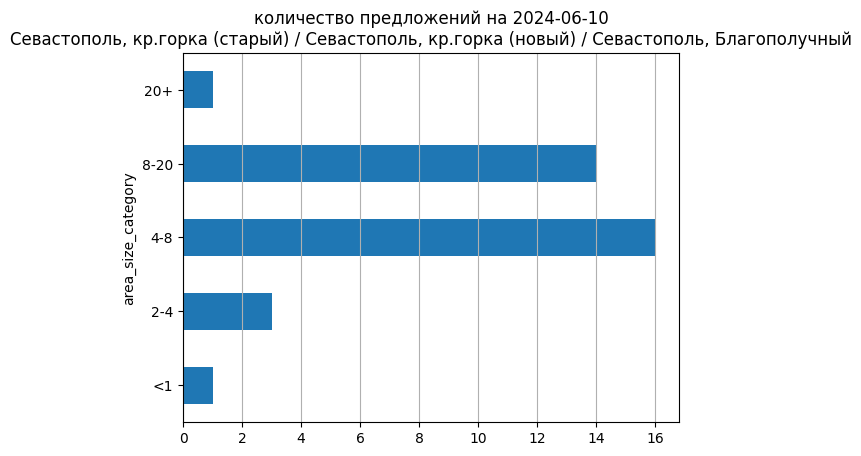

In [53]:
(
        gdf_
        .groupby(['area_size_category'], observed=True)['url'].count()
        .plot.barh(title='количество предложений на '+ str( gdf['dt'].max()) + '\n' + ' / '.join(area_name) )
        .grid(axis='x')    
    )

----

In [54]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 
gdf_local_history = gdf_history.sjoin( frame_, how='inner', predicate='within') 

In [55]:
# stat = gdf_local.groupby(['house_size_category','dt'],observed=True)['priceM'].describe(percentiles=percentiles)
# display( stat )

In [56]:
# sizes = [ '50-70', '70-150', '150-300', ]

In [57]:
percentiles=[.01,.05,.1,.25,.5,.75,.9]
stat = gdf_local.groupby(['area_size_category','dt'],observed=True)['priceM'].describe(percentiles=percentiles)
stat_history = gdf_local_history.groupby(['area_size_category','dt'],observed=True)['priceM'].describe(percentiles=percentiles)

display( stat )
display( stat_history )

count  mean  std  min   1%   5%  10%  25%  50%  \
area_size_category dt                                                           
<1                 2024-06-07   1.00  3.70  NaN 3.70 3.70 3.70 3.70 3.70 3.70   
                   2024-06-10   1.00  3.70  NaN 3.70 3.70 3.70 3.70 3.70 3.70   
2-4                2024-06-04   2.00  4.40 2.26 2.80 2.83 2.96 3.12 3.60 4.40   
                   2024-06-05   2.00  4.40 2.26 2.80 2.83 2.96 3.12 3.60 4.40   
                   2024-06-07   4.00  4.28 2.33 1.80 1.83 1.95 2.10 2.55 4.40   
                   2024-06-10   3.00  3.53 2.19 1.80 1.82 1.90 2.00 2.30 2.80   
4-8                2024-06-04  11.00  5.04 2.45 2.45 2.46 2.50 2.55 3.25 3.90   
                   2024-06-05   9.00  5.84 3.50 2.45 2.46 2.49 2.53 3.10 3.90   
                   2024-06-07  14.00  5.06 2.76 2.45 2.46 2.52 2.71 3.25 4.10   
                   2024-06-10  16.00  5.24 2.68 2.45 2.47 2.52 2.83 3.35 4.35   
8-20               2024-06-04  12.00  6.15 3.63 2.10 2.28 2.98 3.77 4.47 4.95   
                   2024-06-05  13.00  6.37 3.87 2.10 2.29 3.06 3.84 4.50 5.00   
                   2024-06-07  16.00  6.36 4.40 2.10 2.31 3.15 3.50 4.11 4.93   
                   2024-06-10  14.00  5.53 3.95 2.10 2.10 2.10 2.52 3.55 4.60   
20+                2024-06-07   1.00  4.50  NaN 4.50 4.50 4.50 4.50 4.50 4.50   
                   2024-06-10   1.00  4.50  NaN 4.50 4.50 4.50 4.50 4.50 4.50   

                               75%   90%   max  
area_size_category dt                           
<1                 2024-06-07 3.70  3.70  3.70  
                   2024-06-10 3.70  3.70  3.70  
2-4                2024-06-04 5.20  5.68  6.00  
                   2024-06-05 5.20  5.68  6.00  
                   2024-06-07 6.12  6.35  6.50  
                   2024-06-10 4.40  5.36  6.00  
4-8                2024-06-04 6.60  8.00 10.00  
                   2024-06-05 8.00 10.40 12.00  
                   2024-06-07 6.10  8.66 12.00  
                   2024-06-10 6.55  8.75 12.00  
8-20               2024-06-04 6.15  9.27 16.00  
                   2024-06-05 5.50 11.90 16.00  
                   2024-06-07 5.35 14.43 16.00  
                   2024-06-10 5.00 10.59 16.00  
20+                2024-06-07 4.50  4.50  4.50  
                   2024-06-10 4.50  4.50  4.50

count  mean  std  min   1%   5%  10%  25%  50%  \
area_size_category dt                                                           
2-4                2022-09-08   8.00  3.28 1.36 2.45 2.46 2.50 2.56 2.60 2.67   
                   2022-09-12   7.00  2.81 0.42 2.45 2.46 2.50 2.54 2.60 2.65   
                   2022-09-13   7.00  2.81 0.42 2.45 2.46 2.50 2.54 2.60 2.65   
                   2022-09-15   7.00  2.81 0.42 2.45 2.46 2.50 2.54 2.60 2.65   
                   2022-09-16   8.00  2.79 0.40 2.45 2.46 2.50 2.55 2.60 2.62   
                   2022-09-19   8.00  2.75 0.39 2.45 2.46 2.50 2.55 2.60 2.62   
                   2022-09-22   8.00  2.69 0.49 1.90 1.95 2.14 2.39 2.60 2.62   
                   2022-09-26   6.00  2.72 0.58 1.90 1.93 2.07 2.25 2.61 2.67   
                   2022-10-08   8.00  2.65 0.54 1.90 1.92 2.02 2.15 2.36 2.62   
                   2022-10-14   8.00  2.60 0.56 1.90 1.92 2.00 2.11 2.24 2.52   
                   2022-11-01   9.00  2.60 0.50 2.10 2.11 2.14 2.18 2.25 2.40   
                   2022-11-04   9.00  2.60 0.51 2.00 2.02 2.08 2.16 2.35 2.40   
                   2022-11-07   9.00  2.60 0.51 2.00 2.02 2.08 2.16 2.35 2.40   
                   2022-11-15  10.00  2.61 0.46 2.00 2.03 2.16 2.31 2.40 2.45   
                   2022-11-28   8.00  2.54 0.50 2.00 2.02 2.12 2.24 2.35 2.40   
                   2023-01-10   6.00  2.50 0.65 1.90 1.90 1.92 1.95 2.09 2.35   
4-8                2022-09-08  26.00  3.88 2.06 1.60 1.65 1.80 1.90 2.30 3.10   
                   2022-09-12  28.00  3.71 1.83 1.45 1.54 1.80 1.80 2.27 3.25   
                   2022-09-13  27.00  3.53 1.60 1.45 1.54 1.80 1.80 2.25 3.20   
                   2022-09-15  29.00  3.56 1.64 1.45 1.55 1.80 1.80 2.20 3.20   
                   2022-09-16  27.00  3.54 1.67 1.45 1.54 1.80 1.80 2.20 3.20   
                   2022-09-19  26.00  3.70 1.67 1.45 1.54 1.80 1.80 2.23 3.40   
                   2022-09-22  29.00  3.62 1.64 1.45 1.55 1.80 1.80 2.20 3.30   
                   2022-09-26  24.00  3.59 1.55 1.80 1.80 1.80 1.92 2.27 3.10   
                   2022-10-08  28.00  3.70 1.56 1.80 1.80 1.85 1.99 2.27 3.25   
                   2022-10-14  26.00  3.73 1.56 1.80 1.84 1.96 2.10 2.35 3.25   
                   2022-11-01  26.00  3.64 1.53 1.80 1.84 1.96 2.10 2.38 3.15   
                   2022-11-04  22.00  3.54 1.42 1.80 1.83 1.95 2.02 2.60 3.10   
                   2022-11-07  22.00  3.55 1.47 1.70 1.72 1.81 2.02 2.60 3.10   
                   2022-11-15  24.00  3.63 1.67 1.60 1.62 1.72 1.84 2.27 3.15   
                   2022-11-28  25.00  3.87 1.93 1.60 1.62 1.75 1.95 2.20 3.30   
                   2023-01-10  14.00  3.76 1.38 1.50 1.56 1.82 2.09 2.52 4.08   
8-20               2022-09-08  15.00  6.51 4.18 2.50 2.57 2.85 3.00 3.73 4.95   
                   2022-09-12  14.00  6.65 3.82 3.00 3.00 3.00 3.06 4.31 5.08   
                   2022-09-13  15.00  6.45 3.69 3.00 3.00 3.00 3.08 4.38 4.95   
                   2022-09-15  14.00  6.12 3.96 2.15 2.21 2.44 2.72 3.46 4.83   
                   2022-09-16  15.00  6.04 3.82 2.15 2.27 2.75 3.00 3.73 4.70   
                   2022-09-19  14.00  6.33 3.85 2.15 2.26 2.70 3.06 4.31 4.85   
                   2022-09-22  13.00  7.13 4.64 2.15 2.25 2.66 3.04 4.25 5.80   
                   2022-09-26  14.00  6.29 4.19 2.15 2.26 2.70 3.03 4.00 4.60   
                   2022-10-08   9.00  4.84 1.71 2.90 2.91 2.94 2.98 3.60 4.70   
                   2022-10-14  11.00  5.53 3.33 2.90 2.90 2.90 2.90 4.00 4.90   
                   2022-11-01  12.00  5.34 3.32 2.90 2.90 2.90 2.96 3.88 4.45   
                   2022-11-04  11.00  5.14 3.34 2.90 2.96 3.20 3.50 3.70 4.20   
                   2022-11-07  11.00  5.50 4.85 2.90 2.96 3.20 3.50 3.70 4.17   
                   2022-11-15   9.00  5.11 2.96 2.60 2.62 2.72 2.84 3.50 4.20   
                   2022-11-28  12.00  4.95 2.50 2.90 2.97 3.23 3.50 3.58 4.15   
                   2023-01-10   9.00  5.89 4.04 2.50 2.52 2.62

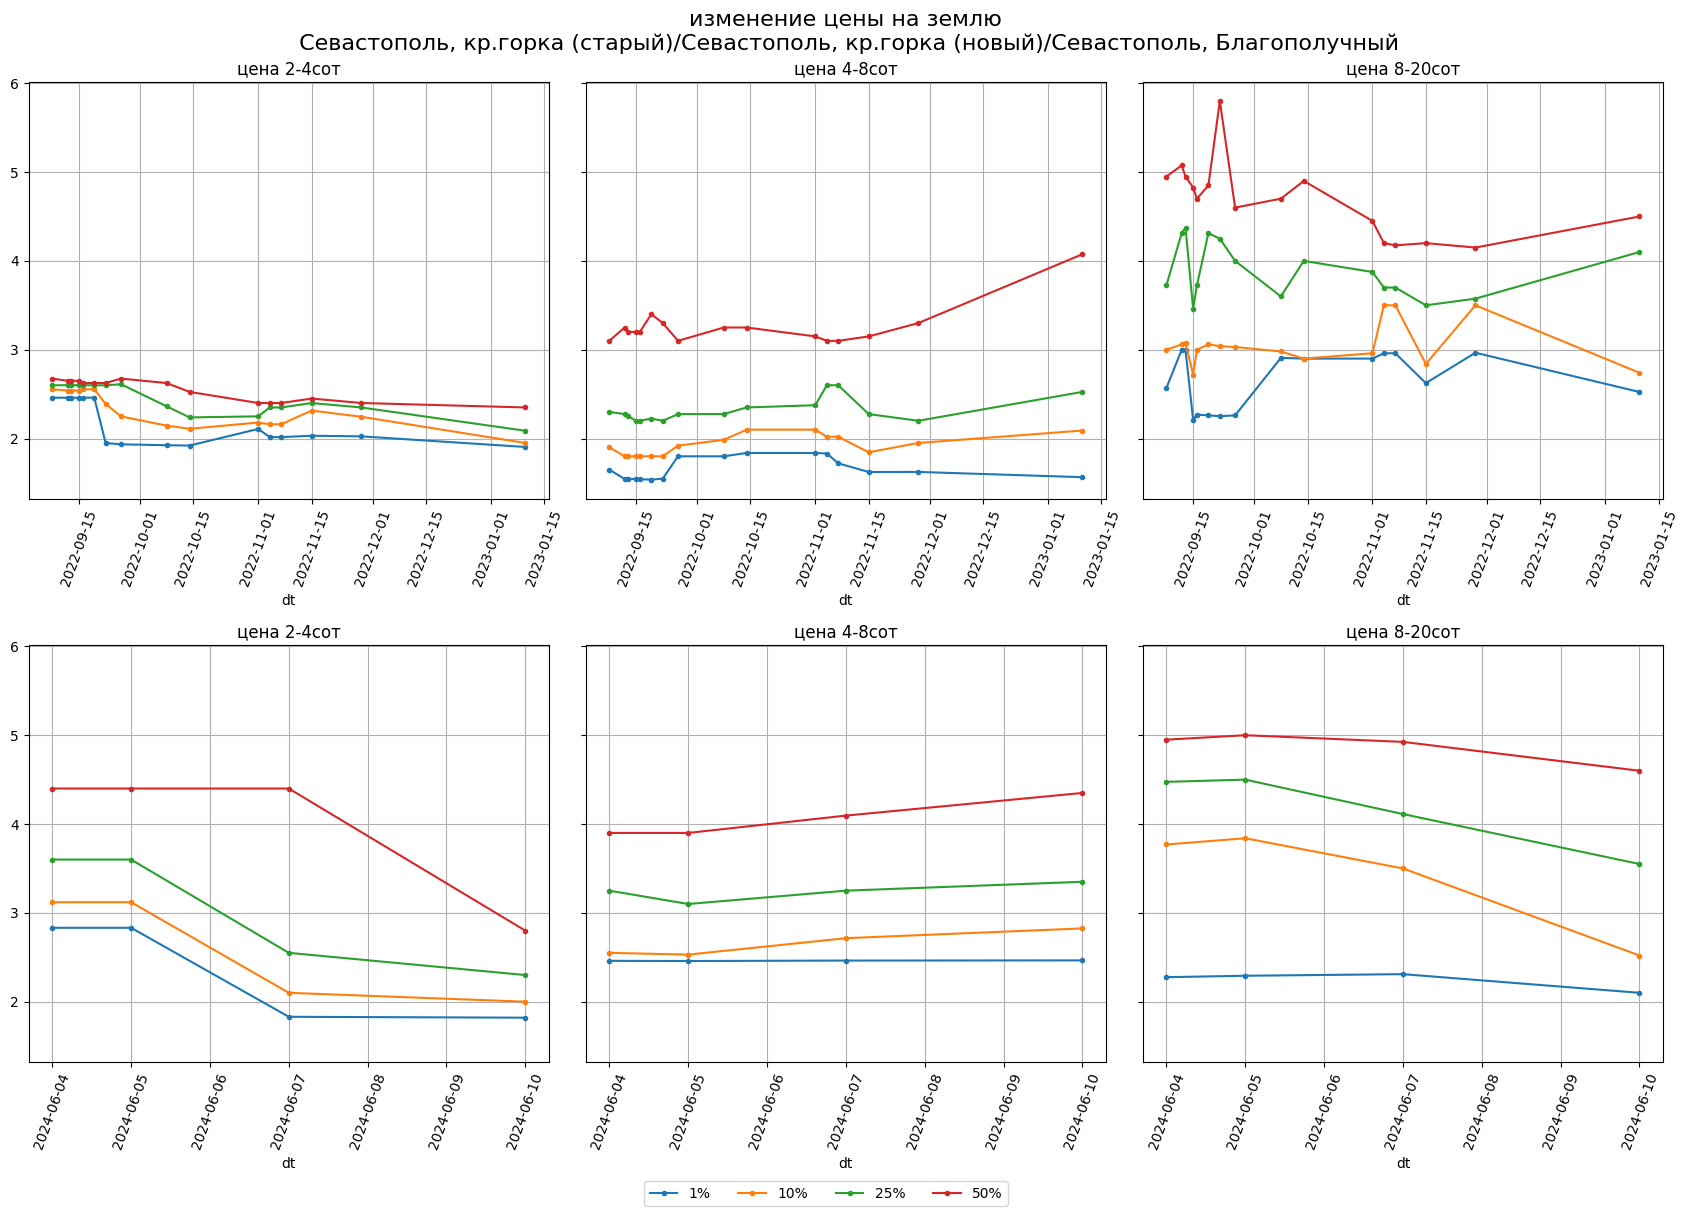

In [58]:
fig, ax = plt.subplots(2,len(sizes),figsize=(17,12), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(s),cols].plot(title=f'цена {s}сот', grid=True,ax=ax[1][i],legend=False, rot=70, style='.-' )   
    stat_history.loc[(s),cols].plot(title=f'цена {s}сот', grid=True,ax=ax[0][i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение цены на землю\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()